In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.models import *
import keras.backend as K
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

Using TensorFlow backend.


In [2]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [3]:
### READ DATA ###

df = pd.read_csv('bbc-text.csv')

print(df.shape)
df.head()

(2225, 2)


,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


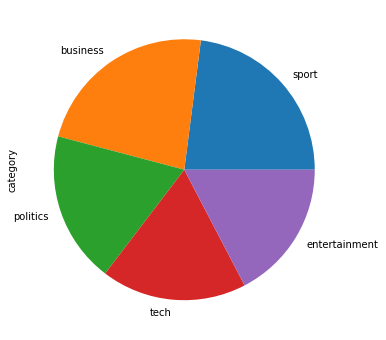

In [4]:
### LABEL DISTRIBUTION ###

df.category.value_counts().plot.pie(figsize=(6,6))

In [5]:
### SIMPLE CLEAN OF TEXT ###

df['text'] = df.text.str.lower().str.replace(r'['+string.digits+string.punctuation+']', ' ')
df['text'] = df['text'].apply(lambda x: x.split())

In [6]:
### SPLIT INTO TRAIN/TEST ###

y = np_utils.to_categorical(df.category.factorize()[0])

X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=33, test_size=0.2)

In [7]:
### MAP LABEL ###

diz_label = {}
for i,label in enumerate(df.category.factorize()[1]):
    diz_label[i] = label
    
diz_label

{0: 'tech', 1: 'business', 2: 'sport', 3: 'entertainment', 4: 'politics'}

In [8]:
### TRAIN WORD2VEC AND FASTTEXT ###

w2v = Word2Vec(size=100, window=5, min_count=4, seed=33)
w2v.build_vocab(X_train)
w2v.train(X_train, total_examples=w2v.corpus_count, epochs=10)

ft = FastText(size=100, window=5, min_count=4, seed=33)
ft.build_vocab(X_train)
ft.train(X_train, total_examples=ft.corpus_count, epochs=10)

In [9]:
### TRANSFORM ORIGINAL TEXT INTO SEQUENCES AND COMPUTE PADDING ###

max_len = 200

tokenizer = Tokenizer(lower=True, split='')
tokenizer.fit_on_texts(X_train)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_train = pad_sequences(sequence_train, maxlen=max_len)

sequence_test = tokenizer.texts_to_sequences(X_test)
sequence_test = pad_sequences(sequence_test, maxlen=max_len)

sequence_train = np.asarray(sequence_train)
sequence_test = np.asarray(sequence_test)

print(sequence_train.shape, sequence_test.shape)

(1780, 200) (445, 200)


In [10]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM WORD2VEC ###

embedding_matrix_w2v = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_w2v[i] = w2v.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 14539


In [11]:
### GET TRAINED WEIGHTS FOR EACH WORD FROM FASTTEXT ###

embedding_matrix_ft = np.random.random((len(tokenizer.word_index) + 1, 100))

pas = 0
for word,i in tokenizer.word_index.items():
    
    try:
        embedding_matrix_ft[i] = ft.wv[word]
    except:
        pas+=1
        
print('not in vocabulary', pas)

not in vocabulary 35


In [12]:
### DEFINE INPUT LAYER FOR EMBEDDINGS READING AND CONCATENATION ###

def Concat_Emb(list_emb, maxlen):
    
    inputs = []
    output = []
    for embedding in list_emb:
        
        inp = Input(shape=(maxlen,))
        emb = Embedding(len(tokenizer.word_index) + 1, 100, weights=[embedding], trainable=False)(inp)
        emb = Reshape((-1,100,1))(emb)
        inputs.append(inp)
        output.append(emb)
        
    concat = Concatenate(axis=-1)(output)
    
    return Model(inputs, concat)

In [13]:
### TRY Concat_Emb ###

read_emb = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
read_emb.summary()

Instructions for updating:
Colocations handled automatically by placer.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     2537000     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     2537000     input_2[0][0]                    
_____________________________________

In [14]:
### DEFINE DME AND CDME BLOCKS ###

def DME(maxlen):

    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, -1))(inp)
    x = LSTM(2, return_sequences=True)(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

def CDME(maxlen, latent_dim=2):
    
    inp = Input(shape=(maxlen, 100, 2))
    x = Reshape((maxlen, -1))(inp)
    x = Bidirectional(LSTM(latent_dim, return_sequences=True))(x)
    x = Lambda(lambda t: [t[:,:,:int(latent_dim/2+1)], t[:,:,int(latent_dim/2+1):]])(x)
    x = Maximum()(x)
    x = Activation('sigmoid')(x)
    x = Reshape((maxlen, 1, 2))(x)
    x = multiply([inp, x])
    out = Lambda(lambda t: K.sum(t, axis=-1))(x)
    
    return Model(inp, out)

In [15]:
### DEFINE NETWORK WITH DME ###

concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
dme = DME(max_len)
x = dme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y.shape[1], activation='softmax')(x)

dme_model = Model(concat_inp.input, out)
dme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

dme_model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 200, 100)     2537000     input_3[0][0]                    
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 200, 100)     2537000     input_4[0][0]               

In [16]:
dme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 1602 samples, validate on 178 samples
Epoch 1/20
 - 13s - loss: 1.4944 - acc: 0.3652 - val_loss: 1.3214 - val_acc: 0.4326
Epoch 2/20
 - 9s - loss: 1.2225 - acc: 0.5200 - val_loss: 1.1980 - val_acc: 0.5225
Epoch 3/20
 - 8s - loss: 1.0898 - acc: 0.5687 - val_loss: 1.1018 - val_acc: 0.5787
Epoch 4/20
 - 8s - loss: 0.9496 - acc: 0.6248 - val_loss: 0.9642 - val_acc: 0.6067
Epoch 5/20
 - 8s - loss: 0.8123 - acc: 0.6923 - val_loss: 0.8165 - val_acc: 0.6404
Epoch 6/20
 - 8s - loss: 0.6729 - acc: 0.7534 - val_loss: 0.7128 - val_acc: 0.7640
Epoch 7/20
 - 8s - loss: 0.6170 - acc: 0.7859 - val_loss: 0.5295 - val_acc: 0.7921
Epoch 8/20
 - 8s - loss: 0.4877 - acc: 0.8283 - val_loss: 0.4060 - val_acc: 0.8652
Epoch 9/20
 - 7s - loss: 0.4056 - acc: 0.8702 - val_loss: 0.3653 - val_acc: 0.8708
Epoch 10/20
 - 7s - loss: 0.3656 - acc: 0.8914 - val_loss: 0.3193 - val_acc: 0.9045
Epoch 11/20
 - 8s - loss: 0.3658 - acc: 0.8789 - val_loss: 0.2755 - val_a

In [17]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)]))

               precision    recall  f1-score   support

     business       0.88      0.93      0.91        90
entertainment       0.94      0.92      0.93        88
     politics       0.98      0.82      0.90        73
        sport       0.98      0.99      0.99       106
         tech       0.89      0.97      0.92        88

     accuracy                           0.93       445
    macro avg       0.94      0.93      0.93       445
 weighted avg       0.94      0.93      0.93       445



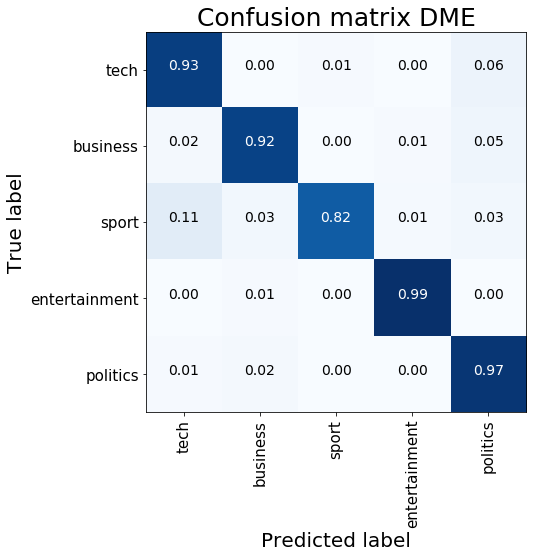

In [18]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(dme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix DME")
plt.show()

In [19]:
### DEFINE NETWORK WITH CDME ###

concat_inp = Concat_Emb([embedding_matrix_w2v, embedding_matrix_ft], maxlen=max_len)
cdme = CDME(max_len)
x = cdme(concat_inp.output)
x = GRU(128, dropout=0.2, return_sequences=True)(x)
x = GRU(32, dropout=0.2)(x)
out = Dense(y.shape[1], activation='softmax')(x)

cdme_model = Model(concat_inp.input, out)
cdme_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

cdme_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 200, 100)     2537000     input_6[0][0]                    
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 200, 100)     2537000     input_7[0][0]                    
__________________________________________________________________________________________________
reshape_7 

In [20]:
cdme_model.fit([sequence_train]*2, y_train, batch_size=128, epochs=20, verbose=2, validation_split=0.1)

Train on 1602 samples, validate on 178 samples
Epoch 1/20
 - 13s - loss: 1.5183 - acc: 0.3377 - val_loss: 1.3605 - val_acc: 0.4157
Epoch 2/20
 - 8s - loss: 1.2733 - acc: 0.5169 - val_loss: 1.2188 - val_acc: 0.4944
Epoch 3/20
 - 8s - loss: 1.1096 - acc: 0.5649 - val_loss: 1.1288 - val_acc: 0.5618
Epoch 4/20
 - 8s - loss: 0.9832 - acc: 0.6248 - val_loss: 0.9249 - val_acc: 0.6404
Epoch 5/20
 - 8s - loss: 0.8229 - acc: 0.6910 - val_loss: 0.7925 - val_acc: 0.7191
Epoch 6/20
 - 8s - loss: 0.7158 - acc: 0.7453 - val_loss: 0.6709 - val_acc: 0.7753
Epoch 7/20
 - 8s - loss: 0.6368 - acc: 0.7971 - val_loss: 0.6690 - val_acc: 0.7472
Epoch 8/20
 - 9s - loss: 0.5736 - acc: 0.8015 - val_loss: 0.5469 - val_acc: 0.7921
Epoch 9/20
 - 8s - loss: 0.4984 - acc: 0.8446 - val_loss: 0.3844 - val_acc: 0.8652
Epoch 10/20
 - 8s - loss: 0.4488 - acc: 0.8564 - val_loss: 0.4290 - val_acc: 0.8708
Epoch 11/20
 - 8s - loss: 0.4226 - acc: 0.8727 - val_loss: 0.3713 - val_acc: 0.8820
Epoch 12/20
 - 8s - loss: 0.4052 - ac

In [21]:
print(classification_report([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                            [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)]))

               precision    recall  f1-score   support

     business       0.85      0.98      0.91        90
entertainment       0.91      0.91      0.91        88
     politics       0.94      0.88      0.91        73
        sport       0.99      0.96      0.98       106
         tech       0.96      0.90      0.93        88

     accuracy                           0.93       445
    macro avg       0.93      0.92      0.93       445
 weighted avg       0.93      0.93      0.93       445



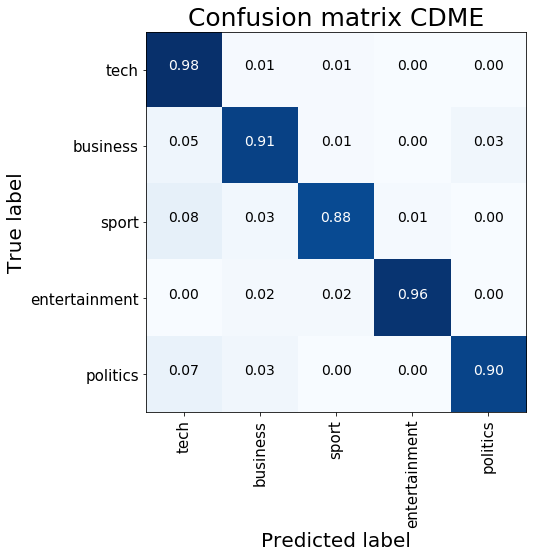

In [22]:
cnf_matrix = confusion_matrix([diz_label[i] for i in np.argmax(y_test, axis=1)], 
                              [diz_label[i] for i in np.argmax(cdme_model.predict([sequence_test]*2), axis=1)])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix CDME")
plt.show()